In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns

import pandas as pd
import numpy as np
from datetime import timedelta, datetime

In [2]:
# Get the route files
import subprocess
subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/gtfs/2015/gtfs_nyct_bus_20150103.zip', 'gtfs_nyct_bus_20150103.zip'), shell=True)
subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150128.csv.xz', 'bus_time_20150128.csv.xz'), shell=True)
subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150129.csv.xz', 'bus_time_20150129.csv.xz'), shell=True)


import zipfile
import lzma
zip = zipfile.ZipFile('gtfs_nyct_bus_20150103.zip')
zip.extractall()

In [3]:
def convert_to_int64(row):
    try:
        return np.int64(row)
    except ValueError:
        return np.nan

def utc_to_est(row):
    try:
        return row - timedelta(hours=5)
    except:
        raise

csv_f = pd.read_csv
archive = pd.concat([csv_f("bus_time_20150128.csv"),
                     csv_f("bus_time_20150129.csv")])        
        
trips = pd.read_csv("trips.txt")
stops = pd.read_csv("stops.txt")
schedules = pd.read_csv("stop_times.txt")

C:\Users\parth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
archive.next_stop_id = archive.next_stop_id.apply(convert_to_int64)

In [5]:
#query and clean
live_archive = archive[archive.block_assigned > 0] # "assigned" to a route
today = live_archive[live_archive.service_date == 20150128] # due to time shift we get some dates in 1/27 and 1/29
#throw away trips with <15 reports
good_trips_only = today.groupby(today.trip_id).filter(lambda group: len(group) > 15)

#write this as our "clean" dataset
good_trips_only.to_csv("realtime.csv")

#merged dataframe with both 
partial = good_trips_only.merge(trips, on='trip_id') 
df = partial.merge(stops, left_on="next_stop_id", right_on="stop_id")

In [6]:
# Select one bus route 
pd.options.display.max_columns = None
m15_only = df[df.route_id.str.contains("M15")].reset_index()
m15_only["timestamp"] = pd.to_datetime(m15_only["timestamp"])

In [7]:
m15_only

,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,161849,2015-01-28 05:23:55,6786,40.803310,-73.933166,233.93,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401738,180.23,108.89,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
1,161850,2015-01-28 05:24:26,6786,40.802600,-73.933682,234.02,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401738,180.23,18.77,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
2,161851,2015-01-28 06:07:21,3904,40.803394,-73.933011,157.83,0,20150128,OH_A5-Weekday-SDon-006000_M15_3,1,401738,180.23,130.16,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
3,161852,2015-01-28 06:07:53,3904,40.802610,-73.933675,234.02,0,20150128,OH_A5-Weekday-SDon-006000_M15_3,1,401738,180.23,20.03,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
4,161853,2015-01-28 06:33:26,3892,40.802570,-73.933704,234.02,0,20150128,OH_A5-Weekday-SDon-009000_M15_4,1,401738,180.23,15.02,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
5,161854,2015-01-28 07:05:57,6702,40.803162,-73.933273,233.93,0,20150128,OH_A5-Weekday-SDon-012000_M15_1,1,401738,180.23,90.11,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
6,161855,2015-01-28 07:06:29,6702,40.802452,-73.933790,234.02,0,20150128,OH_A5-Weekday-SDon-012000_M15_1,1,401738,180.23,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
7,161856,2015-01-28 07:24:48,6786,40.803224,-73.932591,157.39,2,20150128,OH_A5-Weekday-SDon-015000_M15_2,1,401738,180.23,170.21,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
8,161857,2015-01-28 07:25:20,6786,40.803224,-73.932591,157.39,2,20150128,OH_A5-Weekday-SDon-015000_M15_2,1,401738,180.23,170.21,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
9,161858,2015-01-28 07:25:52,6786,40.803224,-73.932591,157.39,2,20150128,OH_A5-Weekday-SDon-015000_M15_2,1,401738,180.23,170.21,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN


In [8]:
m15_reg = m15_only[m15_only.trip_id.str.contains("M15")].reset_index()
m15_sbs = m15_only[m15_only.trip_id.str.contains("SBS")].reset_index()

In [9]:
print('The number of regular M15 buses over 48 hours =',len(m15_reg.trip_id.unique()))
print('The number of express M15 buses over 48 hours =',len(m15_sbs.trip_id.unique()))

The number of regular M15 buses over 48 hours = 257
The number of express M15 buses over 48 hours = 335


In [10]:
#m15_sbs.trip_id.unique()

In [11]:
# Analyze one Regular trip and one Express trip
trip_002000_M15_2 = m15_reg[m15_reg.trip_id.str.contains("002000_M15_2")]
trip_028500_SBS15_1 = m15_sbs[m15_sbs.trip_id.str.contains("029500_SBS15_2")]
trip_028500_SBS15_1
#trip_002000_M15_2.stop_name.unique()

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
3,50,161899,2015-01-28 09:55:27,1285,40.803207,-73.932550,157.39,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401738,180.23,174.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
419,1092,162941,2015-01-28 09:55:59,1285,40.802263,-73.933927,233.97,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401741,910.98,706.8,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
420,1093,162942,2015-01-28 09:56:30,1285,40.799534,-73.935936,234.75,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401741,910.98,359.39,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
421,1094,162943,2015-01-28 09:57:01,1285,40.796938,-73.937821,234.09,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401741,910.98,29.95,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
731,2705,164554,2015-01-28 10:00:14,1285,40.786764,-73.945261,233.68,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405307,3129.23,955.12,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405307,2 AV/E 88 ST,NaN,40.779278,-73.950821,NaN,NaN,0,NaN
732,2706,164555,2015-01-28 10:00:45,1285,40.784579,-73.946848,234.34,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405307,3129.23,677.83,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405307,2 AV/E 88 ST,NaN,40.779278,-73.950821,NaN,NaN,0,NaN
733,2707,164556,2015-01-28 10:01:17,1285,40.782156,-73.948618,233.84,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405307,3129.23,369.72,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405307,2 AV/E 88 ST,NaN,40.779278,-73.950821,NaN,NaN,0,NaN
734,2708,164557,2015-01-28 10:02:20,1285,40.779328,-73.950686,234.21,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405307,3129.23,10.27,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405307,2 AV/E 88 ST,NaN,40.779278,-73.950821,NaN,NaN,0,NaN
1584,3967,165816,2015-01-28 10:02:52,1285,40.778276,-73.951449,233.87,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401756,3919.63,667.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401756,2 AV/E 79 ST,NaN,40.773067,-73.955383,NaN,NaN,0,NaN
1585,3968,165817,2015-01-28 10:03:23,1285,40.776903,-73.952452,233.68,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401756,3919.63,492.72,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401756,2 AV/E 79 ST,NaN,40.773067,-73.955383,NaN,NaN,0,NaN


In [12]:
print(len(trip_002000_M15_2.latitude))
print(len(trip_028500_SBS15_1))

63
67


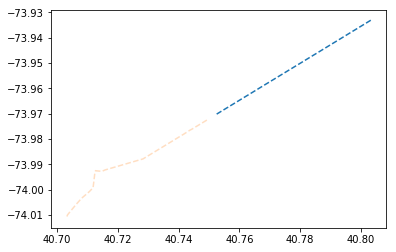

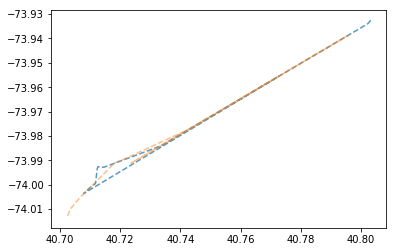

In [13]:
from matplotlib.pylab import plt
# Plot regular route
fig1 = plt.figure()
plt.plot(trip_002000_M15_2.latitude[0:32], trip_002000_M15_2.longitude[0:32], '--', alpha=1)
plt.plot(trip_002000_M15_2.latitude[32:63], trip_002000_M15_2.longitude[32:63], '--', alpha=0.25)
# Plot express route
fig2 = plt.figure()
plt.plot(trip_028500_SBS15_1.latitude[0:35], trip_028500_SBS15_1.longitude[0:35], '--', alpha=0.75)
plt.plot(trip_028500_SBS15_1.latitude[35:67], trip_028500_SBS15_1.longitude[35:67], '--', alpha=0.5)